# 1) Linear and Ridge Regression
#### In this notebook we will get acquainted with the dataset: over 50000 color images of planet Mars. The images are ranked according to the so-called **Local Contrast (LC)** algorithm, which measures image quality for further image processing. Since the quality scores are expressed as a continuous variable, we will build **linear and ridge regression models** to try to mimic the LC algorithm, which we will explore **quantitatively**. Furthermore, and even more importantly, we will evaluate the performance of the models in terms of our **subjective aesthetic judgment**. Will the models surpass the LC algorithm and be able to rank the images in a way more consistent with the "human eye"?   

In [45]:
import planet_utils as utils
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from PIL import Image
import IPython.display as display
import pickle

You must indicate here the path where you saved the Mars images dataset. (Large, 51206 images). The images are already quality-sorted by the PIPP commercial software, according to its LC quality algorithm (first images have highest quality).

In [2]:
folder_qualestimation = '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/' # (This is my own folder path)

### Let us extract the data and familiarize with it

In [3]:
if not(os.path.isfile('whole_arr2d.npy') and os.path.isfile('whole_images_list.pickle')):
    whole_arr2d, _ , whole_images_list = utils.folder_to_data(folder_qualestimation)
    np.save('whole_arr2d', whole_arr2d) # (Note: this will save a large .npy file)
    with open('whole_images_list.pickle', 'wb') as file:
        pickle.dump(whole_images_list, file) # Save a pickle file
else:
    whole_arr2d = np.load('whole_arr2d.npy')
    with open('whole_images_list.pickle', 'rb') as file:
        whole_images_list = pickle.load(file)

In [4]:
# Paths to all subrames. Print the first few ones
whole_images_list[:5]

['/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00000_2022-11-19-1852_7-T-RGB-Mars_f06353_quality_100%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00001_2022-11-19-1852_7-T-RGB-Mars_f03713_quality_99.89%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00002_2022-11-19-1852_7-T-RGB-Mars_f06987_quality_99.76%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00003_2022-11-19-1852_7-T-RGB-Mars_f07882_quality_99.72%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00004_2022-11-19-1852_7-T-RGB-Mars_f02138_quality_99.71%.png']

We can see that the images are already sorted by quality, according to PIPP's Local Contrast algorithm.

Let us now look a the distribution of the images in terms of their quality. 

In [5]:
# Extract the PIPP quality scores (Local Contrast) from the file names, for later analysis
pipp_qual = utils.pipp_qual_parser(whole_images_list)
# Distribution of PIPP scores
pipp_df = pd.DataFrame({"pipp_quality_scores": pipp_qual})
pipp_df.describe()

pipp_quality_scores
count         51206.000000
mean             90.034724
std               2.886028
min              78.720000
25%              88.050000
50%              90.040000
75%              92.040000
max             100.000000

array([[<Axes: title={'center': 'pipp_quality_scores'}>]], dtype=object)

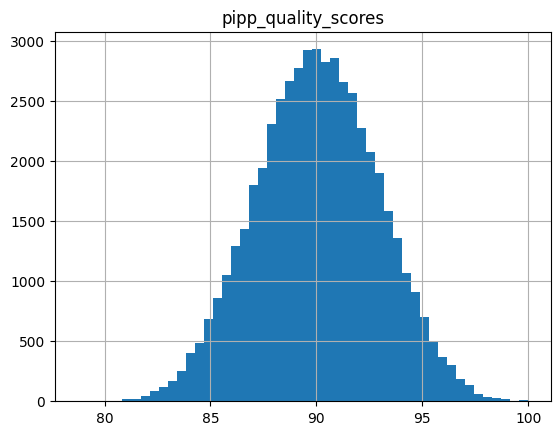

In [6]:
pipp_df.hist("pipp_quality_scores", bins=50)

We can see how PIPP quality scores are centered approximately around the value of 90% and span the range of 78.7% to 100.0%. The data follow what seems to be a normal distribution. 

Let us look now at the image pixel data, from the 2D array (besides the array shape, we inspect only the first sample). 


In [7]:
print(f'Shape: {whole_arr2d.shape}, Min: {np.min(whole_arr2d[0]):.{3}f}, Max: {np.max(whole_arr2d[0]):.{3}f}, Mean: {np.mean(whole_arr2d[0]):.{3}f}, SD: {np.std(whole_arr2d[0]):.{3}f}')

Shape: (51206, 49152), Min: 0.008, Max: 0.933, Mean: 0.209, SD: 0.247


As we can see, will be dealing a very high-dimensional dataset: 49152 variables (the pixel values) per sample. (The pixel values were originally in the range 0-255, but the function *folder_to_data*, which we imported from the *planet_utils* module, took care of rescaling the values between 0 and 1. The same function flattened the data arrays that came from the images; the original format of the images is 128x128x3). 

Finally, let us display some of the highest and lowest rated subframes (the individual images) to familiarize ourselves with them. 

Best images vs. worst images: 


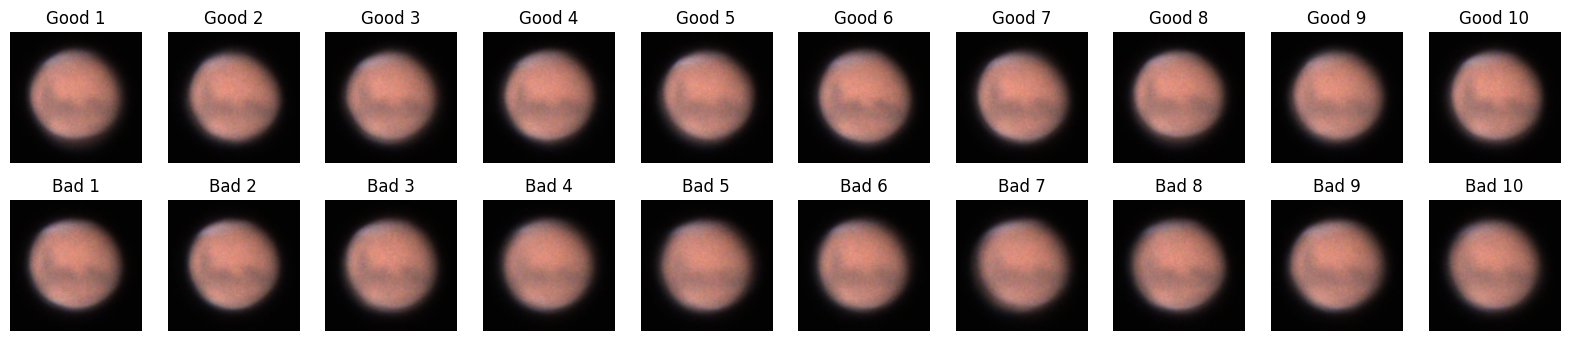

In [8]:
# Show the best and the worst 10
utils.show_best_worst(whole_images_list, show_paths=False)

Perhaps it is helpful to display an already processed image of the "Red Planet" (my best, so far), so that we can discern better some traits on the Martian surface:

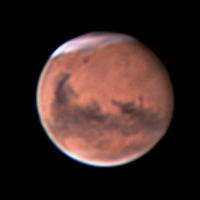

In [9]:
image = Image.open(os.path.join(os.getcwd(), 'mars_processed.png'))
display.display(image.resize((200, 200)))

We can observe a very big white cloud above the North Pole (it is not ice; the cloud disippated after a few days). Syrtis Major Planum, Tyrrhena Terra and Hesperia Planum (the darker terrains accross the center of the disk) are some highlights of the picture. There is also some white haze around the Southern hemisphere. 

In any case, returning to the individual subframes displayed above, it seems hard to notice a big difference between the best and the worst ones in terms of aesthetic quality. 

### Prepare subset

Let us work for now on a smaller images subset, which will speed up our exploration of the data

In [10]:
len_subset = 4000

In [11]:
subset_paths = utils.random_selection(folder_qualestimation, len_subset) 
# Transform to 2D array
subset_arr2d = utils.paths_to_array(subset_paths)
# Get Y (PIPP score) for each image
pipp_score = utils.pipp_qual_parser(subset_paths)


num_samples:  4000
num_pixels:  49152
Shape:  (4000, 49152)


### Linear and Ridge Regression

Since the quality score is continuous, let us create some linear and Ridge regression models to try to predict the quality of the images by providing their pixel values as predictor variables. 

The data (images) involves a tremendous amount of predictor variables (49152, one from each pixel). Thus, we would expect a very high multicollinearity. The data is probably also very noisy. For these reasons, Ridge regression should be more appropriate than plain linear regression, but we will just quickly assess the performance of the latter in any case. 

In [12]:
# Make training and test datasets 
x_train, x_test, y_train, y_test = train_test_split(subset_arr2d, pipp_score, test_size=0.2, random_state=24) 

In [13]:
# Create linear regression model
lin_model = LinearRegression()

In [14]:
# Train the model 
lin_model.fit(x_train, y_train)

LinearRegression()

Now we will compare the model's predictions to the original LC quality scores provided by PIPP. 

In [15]:
lin_pred_values = list(lin_model.predict(subset_arr2d))

In [16]:
pipp_values = utils.pipp_qual_parser(subset_paths)

In [17]:
lin_data_df = pd.DataFrame({'pipp_qual': pipp_values, 'lin_model_qual': lin_pred_values})

In [18]:
# Use score method to get R-squared of linear model
score = lin_model.score(x_test, y_test)
print(score)

0.1769917784417948


$R^2$ seems quite low. But, ultimately, we also want to evaluate the rankings of the Local Contrast algorithm and our models from an aesthetic point of view. Let us compare the best pictures according to PIPP and the linear model. 

In [19]:
# Sort the images according to the linear model
lin_dict = {key: value for key, value in zip(subset_paths, lin_pred_values)}
lin_sorted_paths = sorted(lin_dict.keys(), key=lambda x: lin_dict[x], reverse=True)

LC algorithm.  vs.  Linear Model


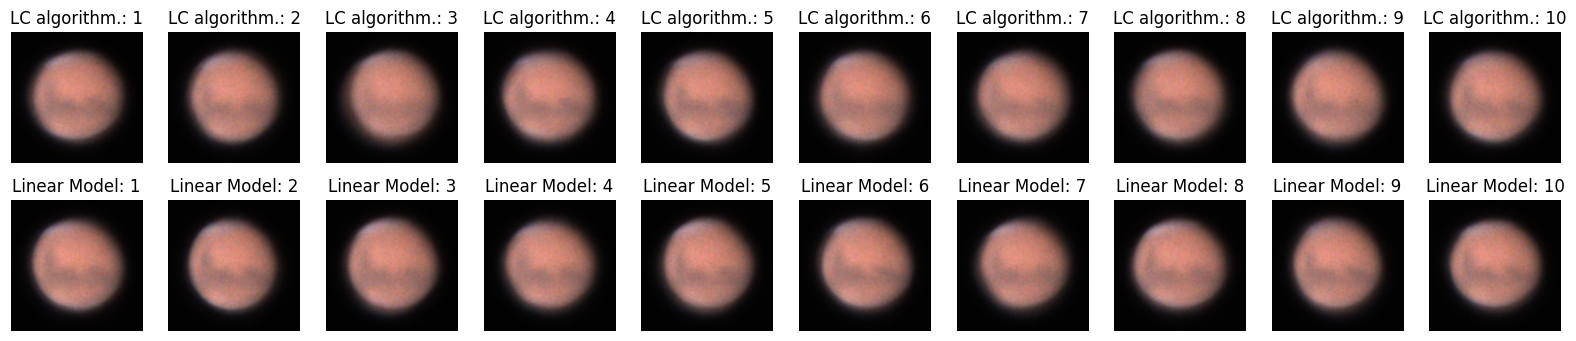

LC algorithm.  vs.  Linear Model


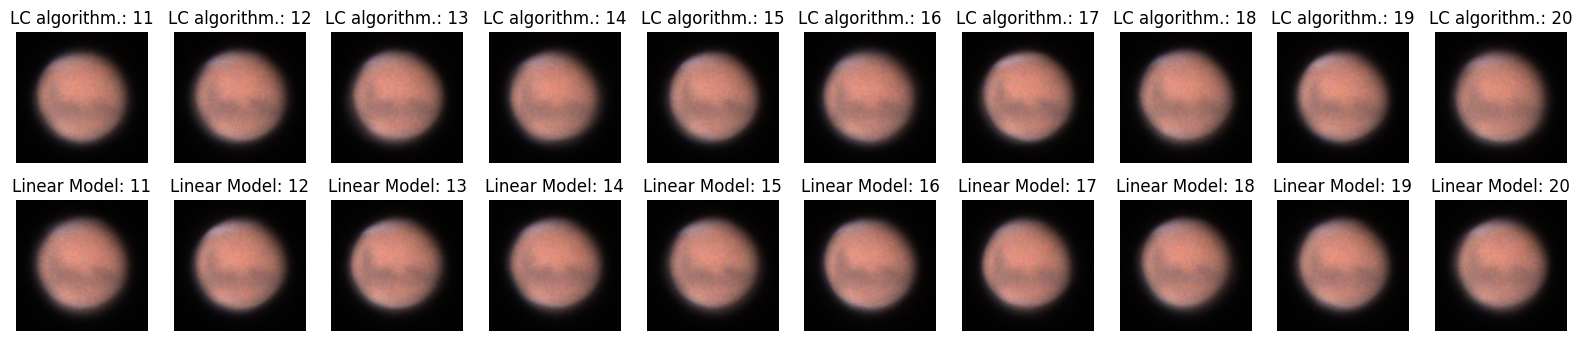

In [20]:
# When running this cell, press <Enter> to get a subsequent subset of 10 best quality images.
# Press <q>, followed by <Enter>, to stop the function. 
utils.images_compare(subset_paths, 'LC algorithm.', lin_sorted_paths, 'Linear Model', 10)

I personally can't find a big difference in aesthetic quality between the best ranked PIPP images and the best ones as predicted by the linear model. 

*(If we wanted to assess the subjective aesthetic quality of the images more rigorously, we would need more thorough methods, for example by comparing many more images and assigning points to them, and also involving several human raters. But we will keep the subjective evaluation method simpler for now, to move on faster).*

#### Ridge regression

From now on, we will work with Ridge regression models. 

In [21]:
ridge_model = Ridge()

If we want to perform some hyperparameter tuning first:

In [22]:
# # Long computation. Uncomment this cell if you want to run it in any case.

# params_Ridge = {'alpha': list(np.logspace(-1, 2, 20)) , "fit_intercept": [True, False]}
# Ridge_GS = GridSearchCV(ridge_model, param_grid=params_Ridge)
# Ridge_GS.fit(x_train,y_train)
# Ridge_GS.best_params_

In [23]:
# The results from the previous cell, at least with one subset of 4000 images, were as follows:
alpha = 23.36
fit_intercept = True

In [24]:
# Define the Ridge regression model
ridge_model = Ridge(alpha = alpha, fit_intercept=True, solver ='auto') 

In [25]:
# Fit the model
ridge_model.fit(subset_arr2d, pipp_score)

Ridge(alpha=23.36)

In [26]:
# Calculate R-squared
score = ridge_model.score(x_test, y_test)
print("R^2: ", score)

R^2:  0.6242182584378528


$R^2$ is a lot higher now, compared with the simple linear model. Let us see how the two quality estimations relate to each other also with a scatterplot:

In [27]:
ridge_pred_values = list(ridge_model.predict(subset_arr2d))
pipp_values = utils.pipp_qual_parser(subset_paths)
ridge_data_df = pd.DataFrame({'pipp_quality': pipp_values, 'ridge_model_quality': ridge_pred_values})

<Axes: xlabel='pipp_quality', ylabel='ridge_model_quality'>

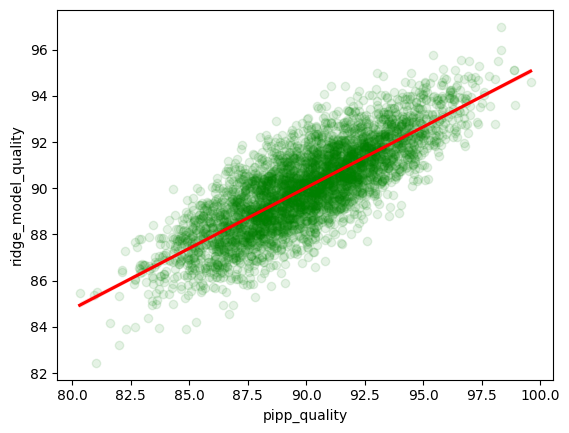

In [28]:
sns.regplot(x='pipp_quality', y='ridge_model_quality', data=ridge_data_df, scatter_kws={"color": "green", 'alpha': 0.1}, line_kws={"color": "red"})

From the $R^2$ calculation and now from the scatterplot, it seems that the Ridge regression model has learned quite well how to rank the images' quality in a way that is analogous to the Local Contrast algorithm's. 

Moving on to subjective quality:

In [29]:
# Sort the images according to the Ridge model
ridge_dict = {key: value for key, value in zip(subset_paths, ridge_pred_values)}
ridge_sorted_paths = sorted(ridge_dict.keys(), key=lambda x: ridge_dict[x], reverse=True)

LC algorithm  vs.  Ridge Model


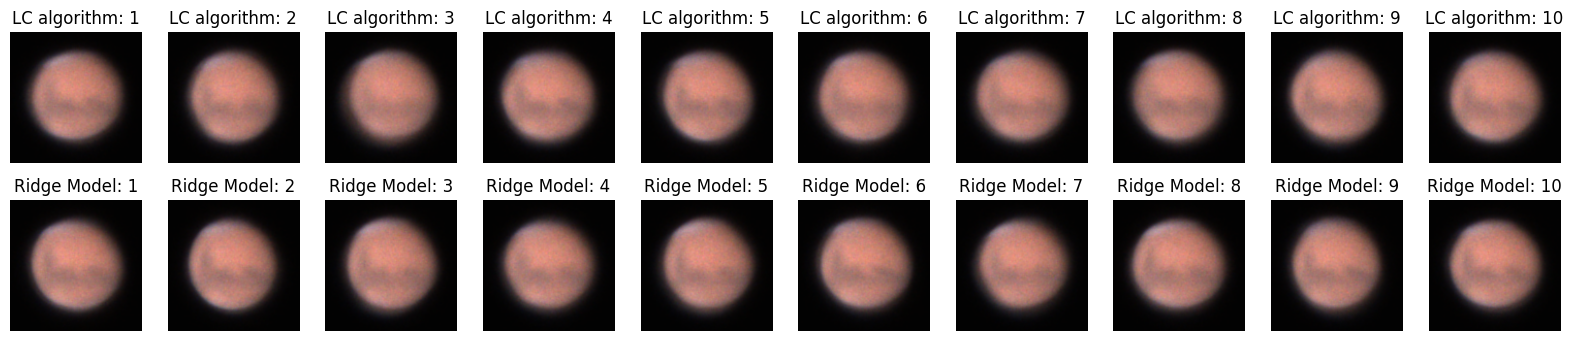

LC algorithm  vs.  Ridge Model


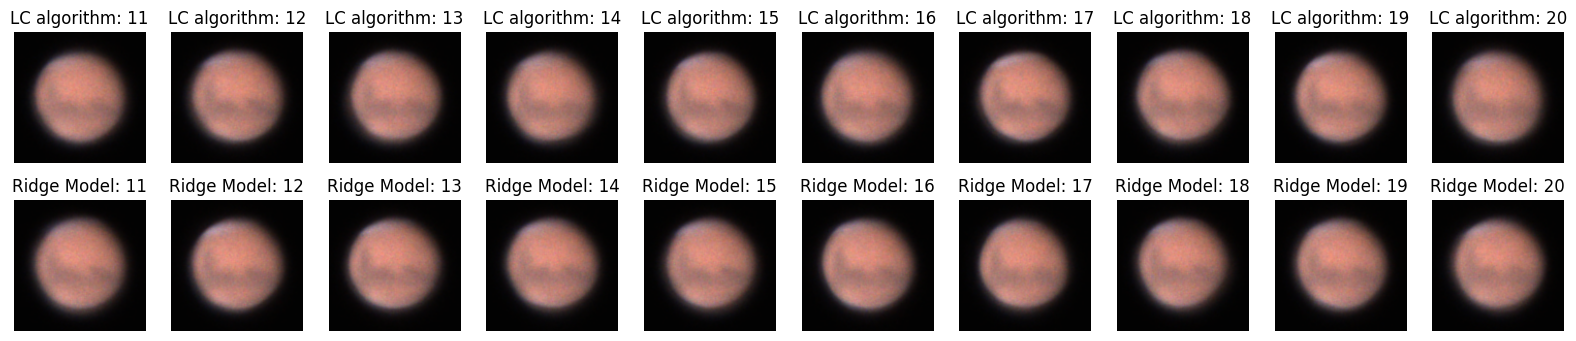

In [30]:
# When running this cell, press <Enter> to get a subsequent subset of 10 best quality images.
# Press <q>, followed by <Enter>, to stop the function. 
utils.images_compare(subset_paths, 'LC algorithm', lin_sorted_paths, 'Ridge Model', 10)

Again, I personally can't find any big aesthetic difference between the two rankings. The Ridge regression model may have learned to predict PIPP's quality scores well, but that doesn't imply that it can show an improvement in terms of subjective quality. 

I obtain similar results when I run the model with larger image subsets. 

### Inspecting the coefficient matrix

I was curious about what the coefficient matrix of the Ridge model has been encoding. Pixel-wise, each coefficient rewards or punishes the pixel values of each image, so I wondered what the coefficient matrix would look like if we plot it like we would just plot a normal image. Would this coefficient-pixel mapping somewhat resemble what we observe on an regular image? Let us explore this possibility.

In [31]:
# Extract coefficients and reshape them as an image
coefficients = ridge_model.coef_
coefficients_3d = coefficients.reshape(128,128,3)

We can change *color_index*, in the plot below, to visualize the coefficients that correspond to each color channel.

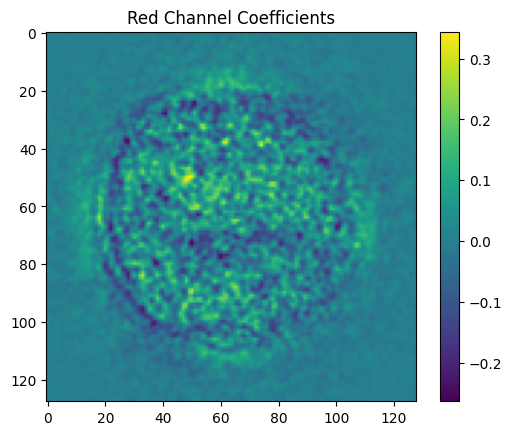

In [32]:
color_index = 0 # As we are dealing with RGB images, 0 corresponds to Red, 1 to Green and 2 to Blue
plt.imshow(coefficients_3d[:, :, color_index], cmap='viridis')  
plt.colorbar()
color_dict = {0:'Red', 1:'Green', 2:'Blue'}
plt.title(color_dict[color_index] + ' Channel Coefficients')
plt.show()

We can observe how the coefficient values "map" the planet disk, its edge, and a little of the other surface traits. But we observe a lot of noise. What will happen if we "hyper-regularize" our ridge model? 

In [33]:
# We substitute alpha by a very, very high value. 
# This might not be too absurd anyway, at least for our exploration, given that we are dealing with very high dimensional data.  
high_alpha = 2000
ridge_high_alpha = Ridge(alpha = high_alpha, fit_intercept=True, solver ='auto')
ridge_high_alpha.fit(x_train, y_train) 

Ridge(alpha=2000)

In [34]:
# New, hyper-regularized coefficients
high_coefficients = ridge_high_alpha.coef_
high_coefficients_3d = high_coefficients.reshape(128,128,3)

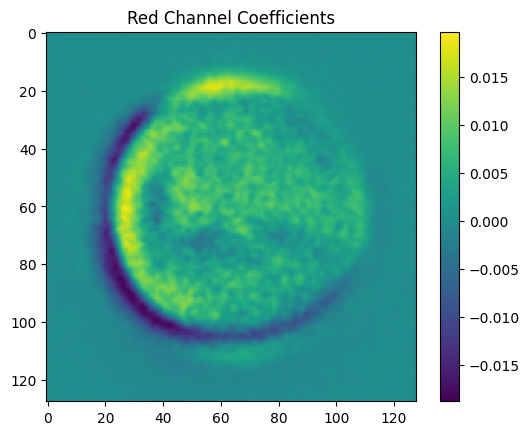

In [35]:
color_index = 0 # 0 corresponds to Red, 1 to Green and 2 to Blue
plt.imshow(high_coefficients_3d[:, :, color_index], cmap='viridis')  
plt.colorbar()
color_dict = {0:'Red', 1:'Green', 2:'Blue'}
plt.title(color_dict[color_index] + ' Channel Coefficients')
plt.show()

This last plot shows a better correspondance with the traits on the Martian planet. For example, some of the highest coefficient values correspond to the white cloud above the Northern Pole, while also some dark areas correspond to areas that are dark in the images. There is also a very dark fringe around the left side border: it is hard to see on single subframes, but on those days Mars was actually starting to wane from that side (the disk was not completely round).  

That gave me an idea. Fitting a model means finding the best parameters for a given dataset. But what if we give the model *our own parameters*? What will happen if we give to a Ridge model (or even to a simple linear model without regularization) a set of coefficients that *look* like an "ideal" image of Mars? This artificial coefficient matrix would act as a sort of mask, "rewarding" in a given image the pixels that were bright when they indeed had to be bright, and conversely with respect to the darker pixels.

I will refer to this synthetic coefficient matrix as a *mask*. Since we already have a processed image of Mars, we will use that one to create the mask. 

In [36]:
# Plot pixel values of processed image of Mars, as we plotted the coefficients before 
proc_path = os.path.join(os.getcwd(), 'mars_processed.png')
proc_arr = utils.paths_to_array([proc_path])
mask_coefficients = proc_arr.reshape(49152)

num_samples:  1
num_pixels:  49152
Shape:  (1, 49152)


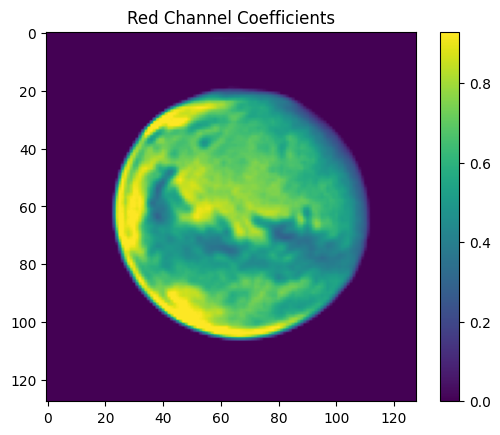

In [37]:
color_index = 0 # 0 corresponds to Red, 1 to Green and 2 to Blue
proc_arr3d = mask_coefficients.reshape(128,128,3)
plt.imshow(proc_arr3d[:, :, color_index], cmap='viridis')  # Replace 0 with the channel index you want to visualize
plt.colorbar()
plt.title('Red Channel Coefficients')
plt.show()

A very simple experiment, but let us use the pixel values of this image directly as a coefficient matrix for a linear model. 

In [38]:
# Instantiate a simple linear regression model
mask_model = LinearRegression()
# Give the model our own coefficients
mask_model.coef_ = mask_coefficients
mask_model.intercept_ = 0

We will be using the whole dataset this time. 

Also, before getting the model's predictions, we will normalize the images, so that each of them has the same average brightness. If, for some reason, there are subframes that are too bright (e.g. I may have accidentally shined some light on the telescope's front during the images acquisition), they will receive higher quality scores than they should without this normalization.  

In [39]:
# Brightness normalization
whole_arr2d = utils.bright_normalize(whole_arr2d)

Overall brightness:  0.2079


In [40]:
whole_predicted_values = list(mask_model.predict(whole_arr2d))

In [41]:
# Sort the images according to the mask model
mask_dict = {key: value for key, value in zip(whole_images_list, whole_predicted_values)}
whole_mask_sorted_paths = sorted(mask_dict.keys(), key=lambda x: mask_dict[x], reverse=True)

To compare the quality of the ranked images:

LC algorithm  vs.  Linear_mask


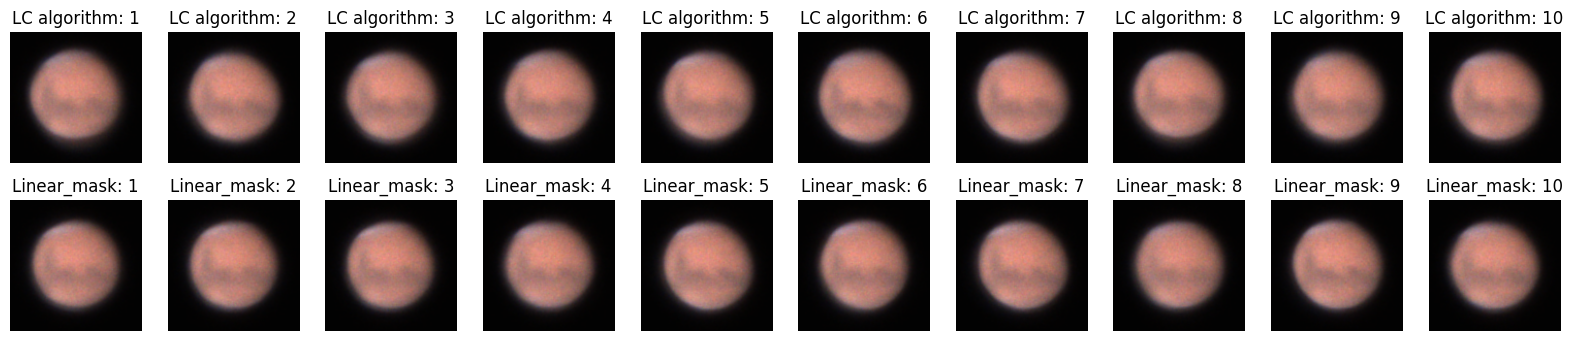

LC algorithm  vs.  Linear_mask


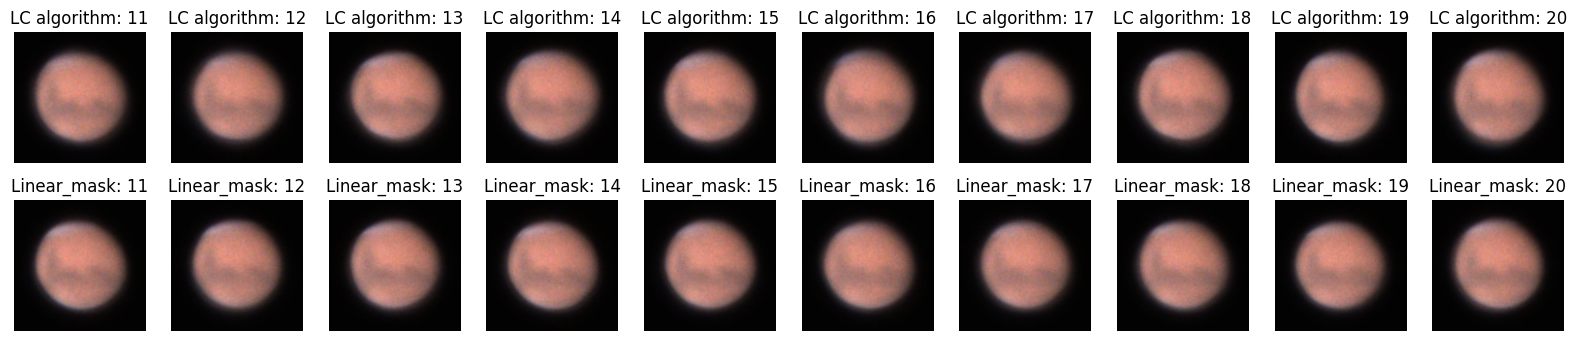

LC algorithm  vs.  Linear_mask


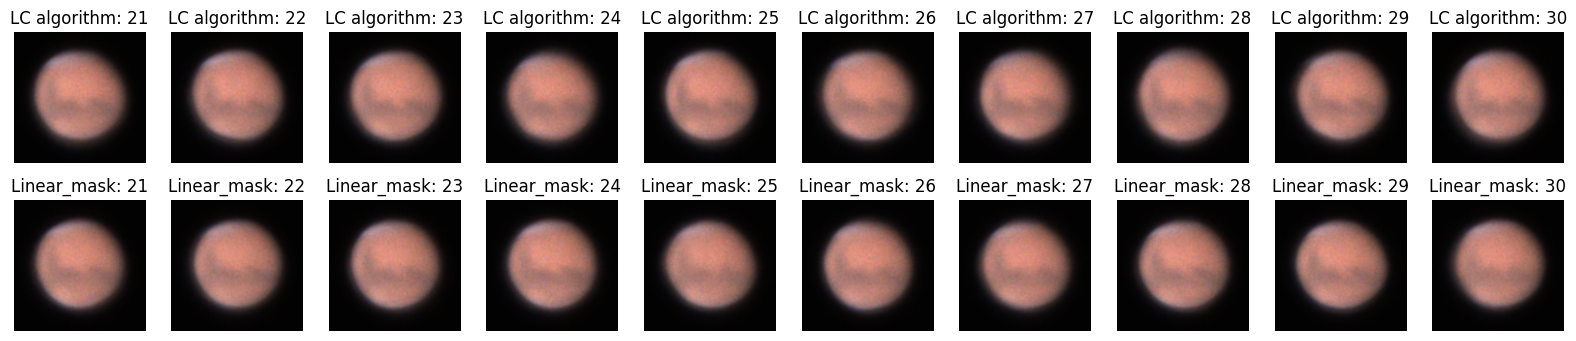

In [43]:
# When running this cell, press <Enter> to get a subsequent subset of 10 best quality images.
# Press <q>, followed by <Enter>, to stop the function.
utils.images_compare(whole_images_list, 'LC algorithm', whole_mask_sorted_paths, 'Linear_mask', 10)

I feel that the new approach ranks the images in a way more consistent with my subjective quality assessment, as compared to the default Local Contrast algorithm. 

I will stack the best 2000 images from both rankings, sharpen them with the same settings, and compare them visually.

In [44]:
# # All the following creates copies of the N best images in folders, to stack them and process with other software.
# # Uncomment if you want to proceed with further processing.  

# pipp_stacking = "pipp_stacking"
# model_stacking = "model_stacking"
# current_directory = os.getcwd()
# pipp_stacking_path = os.path.join(current_directory, pipp_stacking)
# model_stacking_path = os.path.join(current_directory, model_stacking)
# if not os.path.exists(pipp_stacking_path):    
#     os.makedirs(pipp_stacking_path)
# if not os.path.exists(model_stacking_path):    
#     os.makedirs(model_stacking_path)
# num_stack = 2000
# utils.empty_folder(pipp_stacking_path)
# utils.empty_folder(model_stacking_path)
# utils.copy_images(PIPP_whole_paths, pipp_stacking_path, num_stack) 
# utils.copy_images(model_whole_sorted_paths, model_stacking_path, num_stack) 

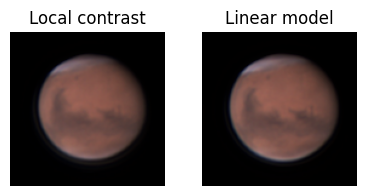

In [46]:
lc_stacked = mpimg.imread(os.path.join(os.getcwd(), 'pipp_stacked.png'))
lin_model_stacked = mpimg.imread(os.path.join(os.getcwd(), 'lin_model_stacked.png'))
utils.display_two_img(lc_stacked, 'Local contrast', lin_model_stacked, 'Linear model')

As we can see, the new model's ranking leads to a stack of subframes that results in a sharper and more defined image.  

### Conclusion

It seems we were able to reproduce quite well the quality ranking behavior of the PIPP software (which uses a Local Contrast algorithm) by using a Ridge regression model. Also, the latter did not appear to rank the images better in terms of aesthetic quality. 

As an experiment, we created a linear model and we imposed on it a coefficient matrix that was based on a processed image of Mars. Following this simple and unorthodox and approach, the model appeared to outperform the LC algorithm at ranking the aesthetic quality of the images. (Further discussion in the Readme file).  